In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle as pkl
sys.path.append('/home/jungyoung/Project/hh_neuralnet/include/')
import hhtools
import hhsignal
import importlib
from tqdm.notebook import tqdm, trange
# other options
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.facecolor'] = 'w'
np.set_printoptions(suppress=True)
from importlib import reload

import oscdetector as od
import hhinfo

In [325]:
summary_obj = hhtools.SummaryLoader("../gen_three_pop_samples_repr/data")

srate = 2000

key_names = ("fpop", "spop")
amp_range_set = [
    dict(fpop=[[]], spop=[[]]), # 1
    dict(fpop=[[]], spop=[[]]), # 2
    dict(fpop=[[20, 30], [40, 50]],
         spop=[[20, 30]]), # 3
    dict(fpop=[[30, 40], [50, 70]],
         spop=[[30, 40]]), # 4
    dict(fpop=[[], [60, 70]],
         spop=[[25, 35], [60, 70]]), # 5 -> tuned
    dict(fpop=[[50, 70]], 
         spop=[[20, 40], [50, 70]]), # 6
    dict(fpop=[[60, 70]],
         spop=[[60, 70]]), # 7
    dict(fpop=[[30, 40], [60, 70]],
         spop=[[30, 40]]), # 8 -> tuned
]

# frequency range are determined based on fourier transform result

Load cache file


In [322]:
def downsample(x, srate, srate_d):
    n = int(srate/srate_d)
    return x[::n]


def digitize_v(v, vrange, nbin):
    v[v < vrange[0]] = vrange[0]
    v[v > vrange[1]] = vrange[1]
    
    de = (vrange[1] - vrange[0])/(nbin-1)
    e = np.arange(vrange[0]-de/2, vrange[1]+de, de)
    
    return np.digitize(v, e)
    
tlag_max = 10
srate = 2000
srate_d = 1000

vrange = [-70, -50]
nbin = 51


In [357]:
def compute_te_on_motif(cid, amp_range, nlag_max, mbin_t=0.01, wbin_t=0.5, q=80, min_len=2, cat_th=2):
    # te = np.zeros((16, 2, nlag_max))
    te_motif = [[] for _ in range(16)]
    len_motif = [[] for _ in range(16)]
    
    for i in trange(200, desc="cid: %d"%(cid)):
        detail_data = summary_obj.load_detail(cid-1, i)
        psd_set, fpsd, tpsd = od.compute_stfft_all(detail_data, mbin_t=mbin_t, wbin_t=wbin_t)
        
        # detect oscillation motif
        words = od.compute_osc_bit(psd_set[1:], fpsd, tpsd, amp_range, q=q, min_len=min_len, cat_th=cat_th)
        osc_motif = od.get_motif_boundary(words)
        
        vf, vs = detail_data["vlfp"][1:]
        vf_d = digitize_v(downsample(vf, srate, srate_d), vrange, nbin)
        vs_d = digitize_v(downsample(vs, srate, srate_d), vrange, nbin)
        
        # add baseline period
        bd = od.get_boundary(words == 0)
        for i in range(len(bd)):
            osc_motif.append({"id": 0, "range": bd[i]})
        
        # compute TE on oscillation motif
        for n in range(len(osc_motif)):
            ido = osc_motif[n]["id"]
            nr = (tpsd[osc_motif[n]["range"]] * srate_d).astype(int)
            
            if nr[1] - nr[0] < nlag_max:
                continue
            
            x = vf_d[nr[0]:nr[1]]
            y = vs_d[nr[0]:nr[1]]
            
            te_motif[ido].append([
                hhinfo.compute_te(x, y, nbin, nlag_max), # fpop -> spop
                hhinfo.compute_te(y, x, nbin, nlag_max), # spop -> fpop
            ])
            len_motif[ido].append(nr[1]-nr[0]) # number of sample points
    
    for ido in range(16):
        te_motif[ido] = np.array(te_motif[ido])
            
    return te_motif, len_motif

In [349]:
nlag_max = int(tlag_max * 1e-3 * srate_d)

te_motif8, len_motif8 = compute_te_on_motif(8, amp_range_set[7], nlag_max)
te_motif5, len_motif5 = compute_te_on_motif(5, amp_range_set[4], nlag_max)

cid: 8:   0%|          | 0/200 [00:00<?, ?it/s]

cid: 5:   0%|          | 0/200 [00:00<?, ?it/s]

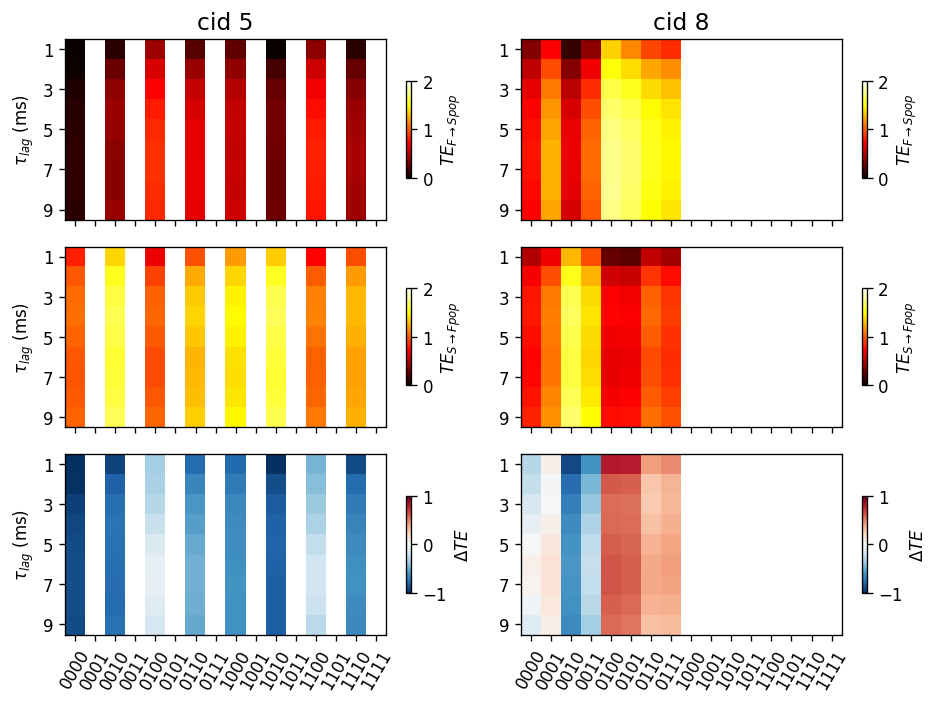

In [446]:
labels = (
    r"$TE_{F\rightarrow S pop}$",
    r"$TE_{S\rightarrow F pop}$"
)


fig, axs = plt.subplots(3, 2, figsize=(8, 6))
for n , te_motif in enumerate([te_motif5, te_motif8]):
    # generate average image
    im_te = np.zeros((2, nlag_max, 16)) * np.nan
    for i in range(16):
        if len(te_motif[i]) == 0: continue
        im_te[:, :, i] = np.average(te_motif[i], axis=0)
        
    im_dte = (im_te[0] - im_te[1]) / (np.max(im_te, axis=0)+1e-13)
    
    for i in range(3):
        plt.axes(axs[i][n])
        if i != 2:
            plt.imshow(im_te[i][1:, :], cmap="hot", vmax=2, vmin=0)
        else:
            plt.imshow(im_dte[1:], cmap="RdBu_r", vmax=1, vmin=-1)
        plt.yticks(np.arange(0, nlag_max-1, 2), labels=np.arange(1, nlag_max, 2))
        plt.xticks(np.arange(16), labels=[])
        if i != 2:
            plt.colorbar(shrink=0.5, label=labels[i])
        else:
            plt.xticks(np.arange(16), labels=od.get_motif_labels(), rotation=60)
            plt.colorbar(shrink=0.5, label=r"$\Delta TE$")

for n in range(3):
    axs[n][0].set_ylabel(r"$\tau_{lag}$ (ms)")


axs[0][0].set_title("cid 5", fontsize=14)
axs[0][1].set_title("cid 8", fontsize=14)

plt.tight_layout()
        

In [475]:
te[0]

array([0.        , 0.86006038, 1.15380358, 1.31094282, 1.41200751,
       1.45793279, 1.47419977, 1.46588041, 1.44689154, 1.42048382])

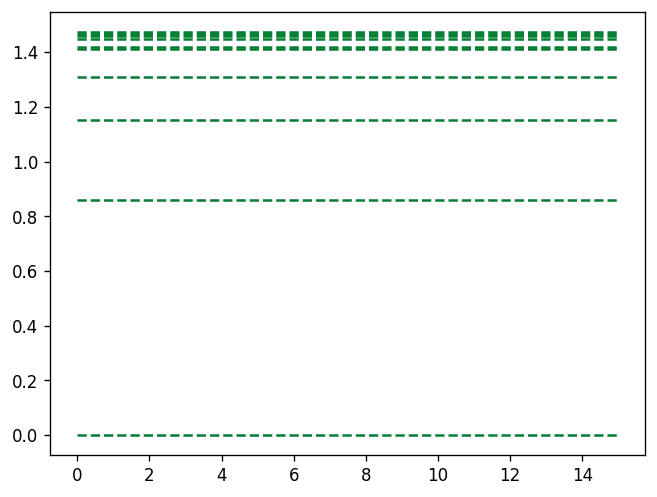

In [473]:
plt.plot([0, 15], [te[0], te[0]], '--', c=cs[n][j])

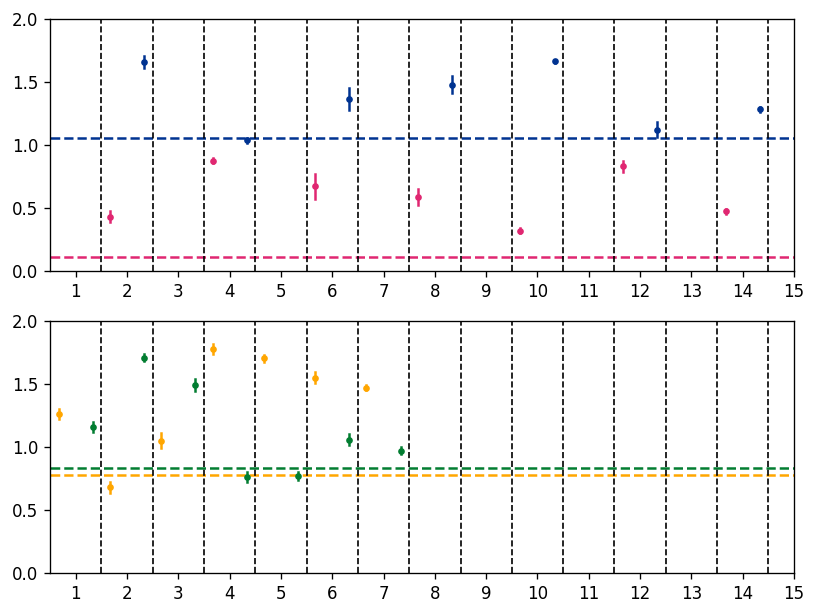

In [494]:
cs = [["#e02771", "#003391"], ["#ffa600", "#027d31"]]
      

plt.figure(figsize=(8, 6))

for n, te_motif in enumerate([te_motif5, te_motif8]):
    plt.subplot(2,1,n+1)
    for i in range(16):
        if len(te_motif[i]) == 0: continue
        te = np.average(te_motif[i], axis=0)
        
        for j in range(2):
            nmax = np.argmax(te[j])
            if i == 0:
                plt.plot([0, 15], [te[j, nmax], te[j,nmax]], '--', c=cs[n][j])
            else:
                x = i + (-1)**(j+1)/3
                m = te[j,nmax]
                plt.plot(x, m, '.', c=cs[n][j])
                s = te_motif[i][:,j,nmax].std() * 1.96/np.sqrt(te_motif[i].shape[0])
                # c = 
                plt.plot([x, x], [m-s, m+s], c=cs[n][j])
    
    for i in range(16):            
        # plt.vlines(i-0.3, 0, 2, color='k', linestyles='--', lw=1)
        plt.vlines(i+0.5, 0, 2, color='k', linestyles='--', lw=1)
            
    plt.xticks(np.arange(1, 16))
    plt.xlim([0.5, 15])

    plt.ylim([0, 2])

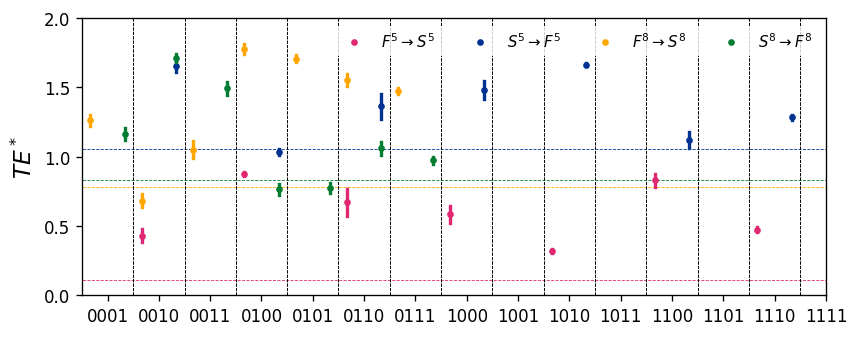

In [528]:
cs = [["#e02771", "#003391"], ["#ffa600", "#027d31"]]
    
labels = [r"$F^5 \rightarrow S^5$", r"$S^5 \rightarrow F^5$", r"$F^8 \rightarrow S^8$", r"$S^8 \rightarrow F^8$"]

plt.figure(figsize=(8, 3))
line_obj = [[] for _ in range(4)]
for n, te_motif in enumerate([te_motif5, te_motif8]):
    # plt.subplot(2,1,n+1)
    for i in range(16):
        if len(te_motif[i]) == 0: continue
        te = np.average(te_motif[i], axis=0)
        
        for j in range(2):
            nmax = np.argmax(te[j])
            if i == 0:
                plt.plot([0, 15], [te[j, nmax], te[j,nmax]], '--', c=cs[n][j], zorder=-1, lw=0.5)
            else:
                x = i + (-1)**(j+1)/3
                m = te[j,nmax]
                line_obj[2*n+j], = plt.plot(x, m, '.', c=cs[n][j])
                s = te_motif[i][:,j,nmax].std() * 1.96/np.sqrt(te_motif[i].shape[0])
                # c = 
                plt.plot([x, x], [m-s, m+s], c=cs[n][j], lw=2)
    
    for i in range(16):            
        # plt.vlines(i-0.3, 0, 2, color='k', linestyles='--', lw=1)
        plt.vlines(i+0.5, 0, 2, color='k', linestyles='--', lw=0.5, zorder=-1)
        
plt.legend(line_obj, labels, ncol=4, loc="upper right", fontsize=9, edgecolor="none")
plt.xticks(np.arange(1, 16), labels=od.get_motif_labels()[1:])
plt.xlim([0.5, 15])
plt.ylim([0, 2])
plt.ylabel(r"$TE^*$", fontsize=14)
plt.yticks(np.arange(0, 2.1, 0.5))
plt.show()

In [530]:
tlag_max

10

In [529]:
nlag_max

10

In [552]:
cs = [["#e02771", "#003391"], ["#ffa600", "#027d31"]]
    
labels = [r"$F^5 \rightarrow S^5$", r"$S^5 \rightarrow F^5$", r"$F^8 \rightarrow S^8$", r"$S^8 \rightarrow F^8$"]

plt.figure(figsize=(8, 3))
line_obj = [[] for _ in range(4)]
for n, te_motif in enumerate([te_motif5, te_motif8]):
    # plt.subplot(2,1,n+1)
    for i in range(16):
        if len(te_motif[i]) == 0: continue
        te = np.average(te_motif[i], axis=0)
        
        for j in range(2):
            nmax = np.argmax(te[j])
            if i == 0:
                plt.plot([0, 15], [nmax, nmax], '--', c=cs[n][j], zorder=-1, lw=1)
                print(nmax)
            else:
                x = i + (-1)**(j+1)/3
                line_obj[2*n+j], =plt.plot(x, nmax, '.', c=cs[n][j])
                
                # m = te[j,nmax]
                # line_obj[2*n+j], = plt.plot(x, m, '.', c=cs[n][j])
                # s = te_motif[i][:,j,nmax].std() * 1.96/np.sqrt(te_motif[i].shape[0])
                # # c = 
                # plt.plot([x, x], [m-s, m+s], c=cs[n][j], lw=2)
    
    for i in range(16):            
        # plt.vlines(i-0.3, 0, 2, color='k', linestyles='--', lw=1)
        plt.vlines(i+0.5, 0, 10, color='k', linestyles='--', lw=0.5, zorder=-1)
        
plt.legend(line_obj, labels, ncol=2, loc="upper right", fontsize=9, edgecolor="none")
plt.xticks(np.arange(1, 16), labels=od.get_motif_labels()[1:])
plt.xlim([0.5, 15])
plt.yticks(np.arange(0, 11))
plt.ylim([2, 10])
plt.ylabel(r"$\tau^* (ms)$", fontsize=14)
plt.show()

In [353]:
te_motif5, len_motif5 = te_motif5
te_motif8, len_motif8 = te_motif8



In [356]:
np.array(te_motif5[0]).shape

(3597, 2, 10)

In [351]:
np.array(te_motif8[0])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (16,) + inhomogeneous part.

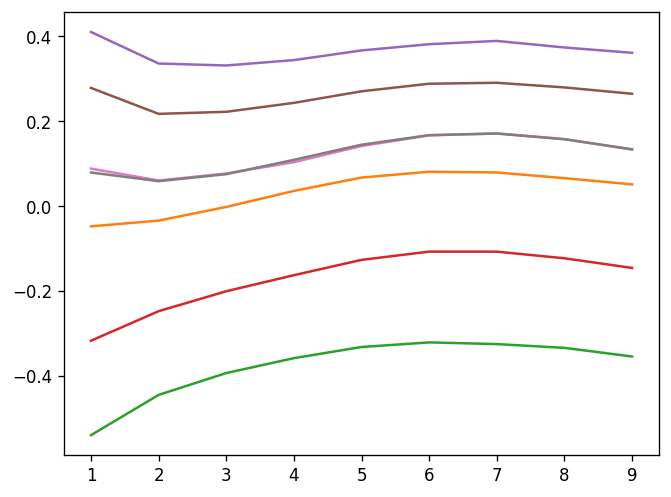

In [ ]:
plt.plot(dte.T)
plt.show()

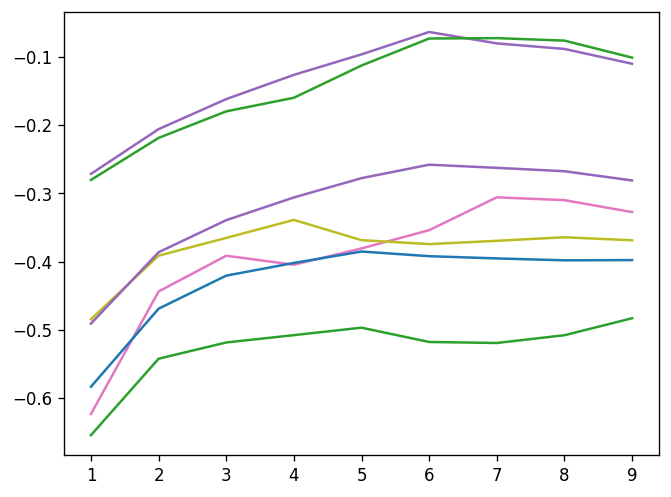

In [315]:
plt.plot(dte.T)
plt.show()

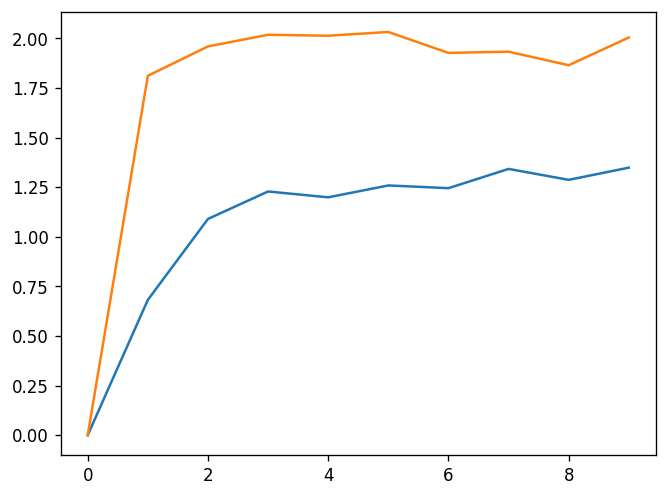

In [301]:
ido = 6

plt.figure()
plt.plot(te[ido, 0])
plt.plot(te[ido, 1])
plt.show()

In [266]:
cid = 5
amp_range = amp_range_set[cid-1]

nlag_max = int(tlag_max * 1e-3 * srate_d)
py = np.zeros((16, nbin))
pyx = np.zeros((16, nbin, nbin))
pyy = np.zeros((16, nbin, nbin, nlag_max))
pyyx = np.zeros((16, nbin, nbin, nbin, nlag_max))

word_count = np.zeros(16)
for i in trange(200):
    detail_data = summary_obj.load_detail(cid-1, i)
    psd_set, fpsd, tpsd = od.compute_stfft_all(detail_data, mbin_t=0.01, wbin_t=0.5)
    
    # detect oscillation motif
    words = od.compute_osc_bit(psd_set[1:], fpsd, tpsd, amp_range, q=80, min_len=2, cat_th=2)
    osc_motif = od.get_motif_boundary(words)
    
    vf, vs = detail_data["vlfp"][1:]
    vf_d = digitize_v(downsample(vf, srate, srate_d), vrange, nbin)
    vs_d = digitize_v(downsample(vs, srate, srate_d), vrange, nbin)
    ts_d = downsample(detail_data["ts"], srate, srate_d)
    
    for n in range(len(osc_motif)):
        ido = osc_motif[n]["id"]
        nr = (tpsd[osc_motif[n]["range"]] * srate_d).astype(int)
        
        if nr[1] - nr[0] < nlag_max:
            continue
        
        # y = vf_d[nr[0]:nr[1]]
        # x = vs_d[nr[0]:nr[1]]
        x = vf_d[nr[0]:nr[1]]
        y = vs_d[nr[0]:nr[1]]
        
        # compute s->f
        py[ido] += hhinfo._count(y, nbin)
        pyx[ido] += hhinfo.compute_joint_hist(y, x, nbin)
        
        for nl in range(1, nlag_max):
            _pyy, _pyyx = hhinfo.compute_prev_hist(y[nl:], y[:-nl], x[:-nl], nbin)
            pyy[ido, :, :, nl] += _pyy
            pyyx[ido, :, :, :, nl] += _pyyx
        
        word_count[ido] += 1
        
    break

# normalize
for ido in range(16):
    py[ido] = hhinfo._norm(py[ido])
    pyx[ido] = hhinfo._norm(pyx[ido])
    
    for nl in range(nlag_max):
        pyy[ido,:,:,nl] = hhinfo._norm(pyy[ido,:,:,nl])
        pyyx[ido,:,:,:,nl] = hhinfo._norm(pyyx[ido,:,:,:,nl])

  0%|          | 0/200 [00:00<?, ?it/s]

In [145]:
te = np.zeros((16, nlag_max))

for ido in range(16):
    hy = hhinfo.compute_ent(py[ido])
    hyx = hhinfo.compute_ent(pyx[ido])

    for nl in range(1, nlag_max):
        hyy = hhinfo.compute_ent(pyy[ido, :, :, nl])
        hyyx = hhinfo.compute_ent(pyyx[ido, :, :, :, nl])
        
        te[ido, nl] = hyy + hyx - hy - hyyx

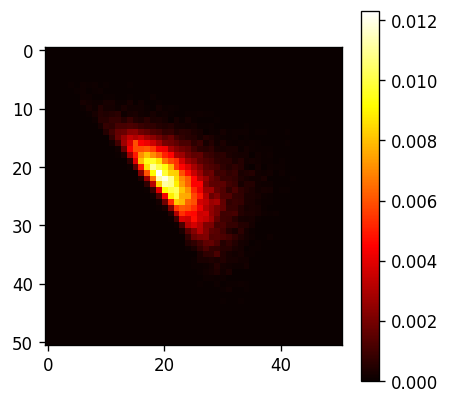

In [175]:
plt.figure(figsize=(4, 4))
plt.imshow(pyy[12, :, :, 3], cmap="hot")
plt.colorbar()
plt.show()

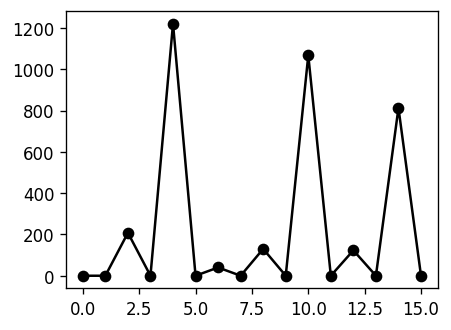

In [146]:
plt.figure(figsize=(4, 3))
plt.plot(word_count, 'ko-')

In [240]:
te_nonzero = []
for n in range(16):
    # te_nonzero[id, n]
    if np.any(te[n] > 0):
        te_nonzero.append(te)


plt.figure(figsize=(4, 4))
plt.plot(te[:, 1:].T, '.-')
plt.show()

IndexError: index 10 is out of bounds for axis 0 with size 10

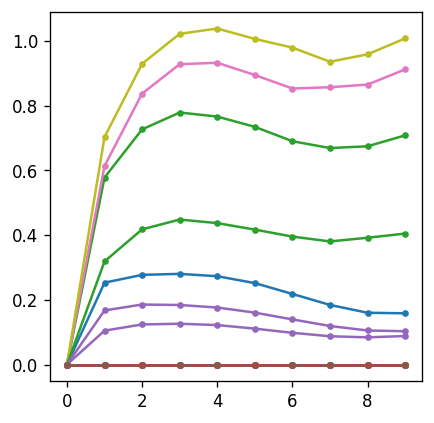

In [143]:
te_nonzero = []
for n in range(16):
    # te_nonzero[id, n]
    if np.any(te[n] > 0):
        te_nonzero.append(te)


plt.figure(figsize=(4, 4))
plt.plot(te.T, '.-')
plt.show()

In [84]:
hhinfo._count

AttributeError: module 'oscdetector' has no attribute '_count'

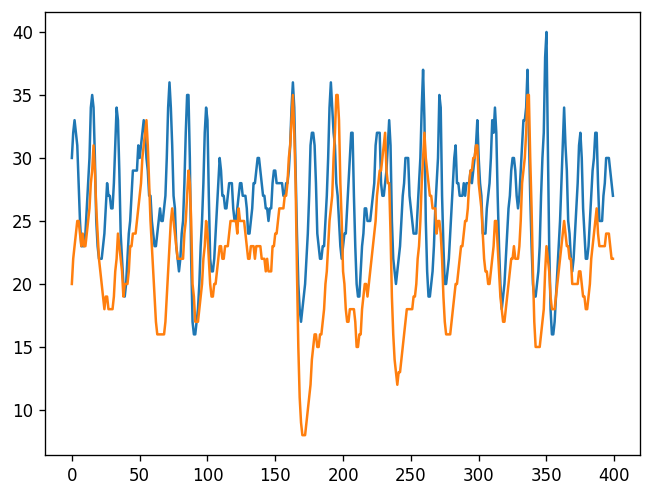

In [82]:
plt.figure()
plt.plot(vf_d_sub)
plt.plot(vs_d_sub)

In [76]:
nr

array([ 9750, 10150])

In [71]:
pyyx.shape

(16, 51, 51, 51, 10)

In [69]:
osc_motif

[{'id': 14, 'range': array([ 8, 39])},
 {'id': 10, 'range': array([68, 81])},
 {'id': 14, 'range': array([177, 206])},
 {'id': 8, 'range': array([311, 315])},
 {'id': 4, 'range': array([348, 361])},
 {'id': 10, 'range': array([389, 401])},
 {'id': 14, 'range': array([414, 432])},
 {'id': 8, 'range': array([440, 446])},
 {'id': 10, 'range': array([482, 491])},
 {'id': 4, 'range': array([509, 515])},
 {'id': 10, 'range': array([537, 553])},
 {'id': 2, 'range': array([576, 583])},
 {'id': 10, 'range': array([629, 633])},
 {'id': 4, 'range': array([692, 701])},
 {'id': 10, 'range': array([720, 730])},
 {'id': 4, 'range': array([738, 756])},
 {'id': 10, 'range': array([775, 802])},
 {'id': 4, 'range': array([831, 850])},
 {'id': 14, 'range': array([885, 914])},
 {'id': 4, 'range': array([933, 944])},
 {'id': 4, 'range': array([950, 990])}]

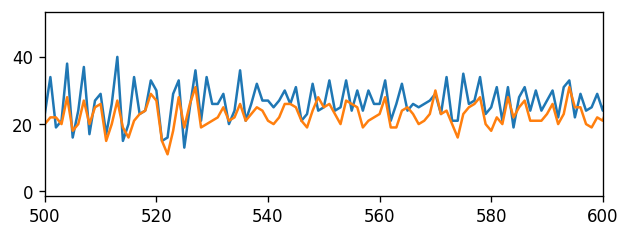

In [57]:
plt.figure(figsize=(6, 2))
plt.plot(vf_d)
plt.plot(vf_s)
plt.xlim([500, 600])

plt.show()